In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import silhouette_score

# =============================
# 1. CHARGEMENT DES DONNÉES
# =============================
df = pd.read_csv("meteofrance.csv", sep=';')
cols = ['AAAAMMJJHH', 'U', ' T','PSTAT']
df = df[cols]

df.rename(columns={
    'AAAAMMJJHH' : 'date' ,
    'U': 'humidity',
    ' T': 'temperature',
    'PSTAT': 'pressure'
}, inplace=True)

cols = ['humidity', 'temperature', 'pressure']
print("Colonnes dispo :", df.columns)

df_feat = df[cols].copy()

missing_codes = [-999.9, 9999, -99.9]
df_feat = df_feat.replace(missing_codes, np.nan)
df_feat = df_feat.interpolate().dropna()
indices_valid = df_feat.index
X = df_feat.values
print("Shape des données (n_samples, n_features) :", X.shape)

Colonnes dispo : Index(['date', 'humidity', 'temperature', 'pressure'], dtype='object')
Shape des données (n_samples, n_features) : (644757, 3)


In [7]:
#=============================
# 2. NORMALISATION
# =============================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =============================
# 3. DEFINITION DU VAE
# =============================

input_dim = X_scaled.shape[1]
latent_dim = 2
# -------- Encoder --------
inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(32, activation='relu')(inputs)
h = layers.Dense(16, activation='relu')(h)

z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# -------- Decoder --------
latent_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
h_dec = layers.Dense(16, activation='relu')(latent_inputs)
h_dec = layers.Dense(32, activation='relu')(h_dec)
outputs = layers.Dense(input_dim, activation='linear')(h_dec)

decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

# -------- Classe VAE --------
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Loss de reconstruction (MSE somme par échantillon)
            rec_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=1)
            )

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = rec_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": rec_loss,
            "kl_loss": kl_loss
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │        528 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 724 (2.83 KB)

 Trainable params: 724 (2.83 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691 (2.70 KB)

 Trainable params: 691 (2.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - kl_loss: 0.8853 - loss: 2.4207 - reconstruction_loss: 1.5355
Epoch 2/10
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - kl_loss: 0.9436 - loss: 2.3796 - reconstruction_loss: 1.4361
Epoch 3/10
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - kl_loss: 0.9492 - loss: 2.3728 - reconstruction_loss: 1.4237
Epoch 4/10
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - kl_loss: 0.9470 - loss: 2.3696 - reconstruction_loss: 1.4227
Epoch 5/10
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - kl_loss: 0.9501 - loss: 2.3699 - reconstruction_loss: 1.4199
Epoch 6/10
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - kl_loss: 0.9521 - loss: 2.3678 - reconstruction_loss: 1.4158
Epoch 7/10
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - kl_loss: 0.9521 - loss: 2.3648 - reconstruction_loss: 1.4127
Epoch 8/10
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - kl_loss: 0.9557 - loss: 2.3663 - reconstruction_loss: 1.4108
Epoch 9/10
20149/20149 ━━━━━━━━━━━━━━━━━

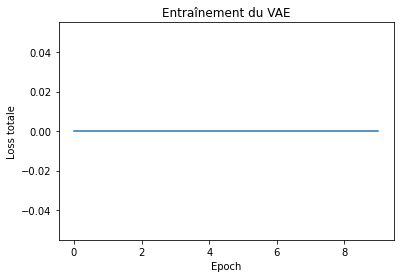

In [8]:
# =============================
# 4. ENTRAÎNEMENT
# =============================

history = vae.fit(
    X_scaled,
    epochs=10,
    batch_size=32,
    shuffle=True,
    verbose=1
)

# Visualisation de la loss
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss totale")
plt.title("Entraînement du VAE")
plt.show()


20149/20149 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step
20149/20149 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
Seuil d'anomalie : 1.9311436109952622
Nombre d'anomalies détectées : 6448 / 644757


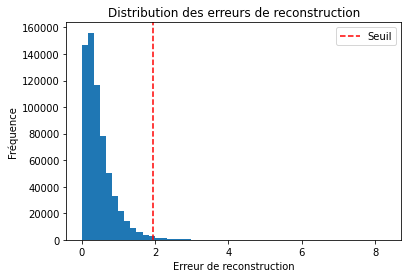

In [9]:
# =============================
# 5. ERREUR DE RECONSTRUCTION & ANOMALIES
# =============================
z_mean, z_log_var, z = encoder.predict(X_scaled)
X_rec = decoder.predict(z)

# Erreur MSE par échantillon
reconstruction_error = np.mean((X_scaled - X_rec)**2, axis=1)

# Choix d'un seuil : 99ème percentile (tu peux tester 95, 97.5...)
threshold = np.percentile(reconstruction_error, 99)
print("Seuil d'anomalie :", threshold)

anomaly_mask = reconstruction_error > threshold
n_anomalies = np.sum(anomaly_mask)
print("Nombre d'anomalies détectées :", n_anomalies, "/", len(reconstruction_error))

# Données anormales (normalisées + latent)
X_anom_scaled = X_scaled[anomaly_mask]
Z_anom = z[anomaly_mask]
indices_anom = indices_valid[anomaly_mask]

# Distribution des erreurs
plt.hist(reconstruction_error, bins=50)
plt.axvline(threshold, color='r', linestyle='--', label='Seuil')
plt.xlabel("Erreur de reconstruction")
plt.ylabel("Fréquence")
plt.legend()
plt.title("Distribution des erreurs de reconstruction")
plt.show()

/home/cheikh/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cheikh/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cheikh/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cheikh/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

Meilleur nombre de clusters (k) selon le score de silhouette : 3
Répartition des anomalies par cluster :
Cluster 0 : 2300 anomalies
Cluster 1 : 1861 anomalies
Cluster 2 : 2287 anomalies


/home/cheikh/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


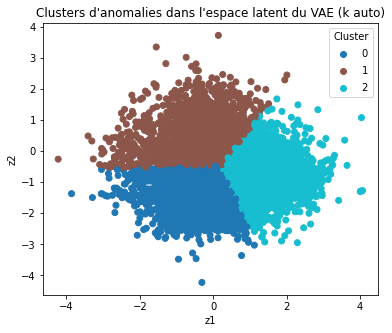

In [10]:
# =============================
# 6. CLUSTERING DES ANOMALIES (K-MEANS) AVEC CHOIX AUTOMATIQUE DE k
# =============================

if n_anomalies > 0:
    # Il faut au minimum quelques points pour faire du clustering
    if n_anomalies < 3:
        print("Trop peu d'anomalies pour faire du clustering fiable.")
        labels_anom = np.zeros(n_anomalies, dtype=int)
        best_k = 1
    else:
        # On va tester plusieurs valeurs de k et choisir celle qui maximise le score de silhouette
        possible_ks = range(2, min(10, n_anomalies))  # on ne peut pas avoir plus de clusters que de points
        silhouette_scores = []

        for k in possible_ks:
            kmeans_tmp = KMeans(n_clusters=k, random_state=0)
            labels_tmp = kmeans_tmp.fit_predict(Z_anom)
            score = silhouette_score(Z_anom, labels_tmp)
            silhouette_scores.append(score)

        # choix du meilleur k
        best_k = possible_ks[np.argmax(silhouette_scores)]
        print("Meilleur nombre de clusters (k) selon le score de silhouette :", best_k)

        # Clustering final avec ce k
        kmeans = KMeans(n_clusters=best_k, random_state=0)
        labels_anom = kmeans.fit_predict(Z_anom)

        print("Répartition des anomalies par cluster :")
        for k in range(best_k):
            print(f"Cluster {k} : {(labels_anom == k).sum()} anomalies")

        # Visualisation des anomalies dans l'espace latent
        plt.figure(figsize=(6, 5))
        scatter = plt.scatter(Z_anom[:, 0], Z_anom[:, 1], c=labels_anom, cmap="tab10")
        plt.xlabel("z1")
        plt.ylabel("z2")
        plt.title("Clusters d'anomalies dans l'espace latent du VAE (k auto)")
        plt.legend(*scatter.legend_elements(), title="Cluster")
        plt.show()
else:
    print("Aucune anomalie détectée avec ce seuil.")

In [11]:
# =============================
# 7. RETOUR AUX VALEURS PHYSIQUES
# =============================

# Retour à l'échelle d'origine
X_anom_original = scaler.inverse_transform(X_anom_scaled)

anom_df = pd.DataFrame(
    X_anom_original,
    columns=cols,
    index=indices_anom
)

if n_anomalies > 0:
    anom_df["cluster"] = labels_anom

print("Exemple d'anomalies détectées :")
print(anom_df.head())


Exemple d'anomalies détectées :
     humidity  temperature  pressure  cluster
46       88.0          8.9    1026.2        0
232      56.0         13.2    1020.8        2
234      74.0          9.1    1022.0        2
408      65.0         12.4     992.6        0
431      93.0          3.8    1000.1        2
